In [1]:
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.ERROR)

import json
import gzip
import hashlib
import pandas as pd
from rdkit import Chem
import rdkit.Chem.AllChem as AllChem

from joblib import Parallel, delayed
from time import time

from rdradical import extractor_radical_invert

In [2]:
def can_parse(rsmi):
    react, spec, prod = rsmi.split('>')
    if Chem.MolFromSmiles(react) and Chem.MolFromSmiles(prod):
        return True
    else:
        return False
    
t0 = time()

test_temp = pd.read_csv('data\\test_reaction_random500.csv')#, sep='\t')

test_temp['ReactionSmiles'] = test_temp['ReactionSmiles'].str.split(' ', expand=True)[0]
split_smiles = test_temp['ReactionSmiles'].str.split('>', expand=True)
test_temp['reactants'] = split_smiles[0]
test_temp['spectators'] = split_smiles[1]
test_temp['products'] = split_smiles[2]

parsable = Parallel(n_jobs=-1, verbose=1)(delayed(can_parse)(rsmi) for rsmi in test_temp['ReactionSmiles'].values)
# parsable = uspto['ReactionSmiles'].map(can_parse)

test_temp = test_temp[parsable]
print('{} parsable reactions'.format(len(test_temp)))

hexhash = (test_temp['ReactionSmiles']+str(test_temp['ReactionNumber'])).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

test_temp['source'] = 'b97d3'
test_temp['source_id'] = hexhash
test_temp = test_temp.reset_index().rename(columns={'index': '_id'})
reactions = test_temp[['_id', 'reactants', 'products', 'spectators', 'source', 'source_id']]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s


500 parsable reactions


[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.3s finished


In [3]:
reactions.head(5)

,_id,reactants,products,spectators,source,source_id
0,0,[C:1]1([H:7])([H:8])[C:2]([H:9])([H:10])[C@:3]...,[C:1]1([H:7])([H:8])[C:2]([H:9])([H:10])[C@@:3...,,b97d3,85c7aac47ee49ff353391df4c0e03800f4d0a93fd885aa...
1,1,[C:1](#[C:2][c:3]1[c:4]([H:9])[n:5][n:6][n:7]1...,[C:1](=[C:2]=[C:3]1[C:4]([H:9])=[N:5][N:6]=[N:...,,b97d3,b9160685471963b4f7ac1022612ab80f0e355f5e1db836...
2,2,[C:1]([C@@:2]1([H:11])[C:3]([H:12])([H:13])[C@...,[C:1]([C:2]([C:3]([C:4][C:5]([C:6](=[O:7])[H:1...,,b97d3,9616aae68d8cf21709535c397338e255ae6278bb5502dc...
3,3,[N:1]#[C:2][C@@:3]1([H:8])[C:4]([H:9])([H:10])...,[N:1]#[C:2][C:4](/[C:3](=[N:7]/[H:12])[H:8])([...,,b97d3,727cb0bae6b0e8fea79858ed7b237ca1c64a49a38c07fa...
4,4,[C:1]([C@@:2]1([H:11])[C:3]([H:12])([H:13])[C@...,[C:1]([C@@:2]1([H:11])[C:3]([H:12])([H:13])[C@...,,b97d3,08f1451207a79269694df8fd9f30373af2f8e887c590d4...


In [4]:
reactions.to_json('data/test_reactions.json.gz', orient='records', compression='gzip')

with gzip.open('data/test_reactions.json.gz') as f:
    reactions = json.load(f)

def extract(reaction):
    try:
        return extractor_radical_invert.extract_from_reaction(reaction)
    except KeyboardInterrupt:
        print('Interrupted')
        raise KeyboardInterrupt
    except Exception as e:
        print(e)
        return {'reaction_id': reaction['_id']}

templates = Parallel(n_jobs=-1, verbose=4)(delayed(extract)(reaction) for reaction in reactions)
#with gzip.open('data/uspto.templates.json.gz', 'w') as f:
with open('data/test_temp.json', 'w') as f:
    json.dump(templates, f)
    
print('elapsed seconds: {}'.format(int(time()-t0)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s


elapsed seconds: 2


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


In [5]:
with open('data/test_temp.json') as f:
    templates = json.load(f)

In [6]:
templates[121]

{'products': '([#1&+0:1]-[O&+0:5]-[C:6].[C:3]-[C&+0:2]-[C:4])',
 'prod_temp_radical': {'2': 2},
 'reactants': '([#1&+0:1]-[C@@&+0:2](-[C:3])(-[C:4])-[O&+0:5]-[C:6])',
 'react_temp_radical': {},
 'reaction_smarts': '([#1&+0:1]-[C@@&+0:2](-[C:3])(-[C:4])-[O&+0:5]-[C:6])>>([#1&+0:1]-[O&+0:5]-[C:6].[C:3]-[C&+0:2]-[C:4])',
 'intra_only': True,
 'dimer_only': False,
 'reaction_id': 121,
 'necessary_reagent': ''}

In [7]:
reaction_id_to_index = {x['_id']: i for i, x in enumerate(reactions)} # from the '_id' of reaction to the entry (where template extract)
def sep_bar():
    print('')
    for i in range(3):
        print('='*80)
    print('')

In [8]:
RDKIT_SMILES_PARSER_PARAMS = Chem.SmilesParserParams()
def str_to_mol(string: str, explicit_hydrogens: bool = True) -> Chem.Mol:

    if string.startswith('InChI'):
        mol = Chem.MolFromInchi(string, removeHs=not explicit_hydrogens)
    else:
        # Set params here so we don't remove hydrogens with atom mapping
        RDKIT_SMILES_PARSER_PARAMS.removeHs = not explicit_hydrogens
        mol = Chem.MolFromSmiles(string, RDKIT_SMILES_PARSER_PARAMS)

    if explicit_hydrogens:
        return mol
        #return Chem.AddHs(mol)
    else:
        return Chem.RemoveHs(mol)

def show_k(k):
    if 'reaction_smarts' not in templates[k]:
        return
    print(k)
    # the kth template correspoding to the ['reaction_id']th reactions
    reaction = reactions[reaction_id_to_index[templates[k]['reaction_id']]]  
    display(str_to_mol(reaction['reactants'])) 
    print('Reactant radicals: {}'.format(templates[k]['react_temp_radical']))
    print('Reactants: {}'.format(reaction['reactants']))
    display(str_to_mol(reaction['products']))
    print('Reactant radicals: {}'.format(templates[k]['prod_temp_radical']))
    print('Products: {}'.format(reaction['products']))
    display(AllChem.ReactionFromSmarts(templates[k]['reaction_smarts']))
    print('Extracted template: {}'.format(templates[k]['reaction_smarts']))
    sep_bar()

38


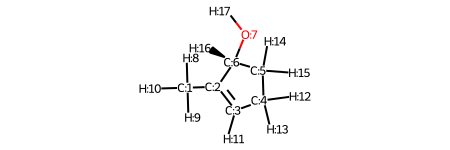

Reactant radicals: {}
Reactants: [C:1]([C:2]1=[C:3]([H:11])[C:4]([H:12])([H:13])[C:5]([H:14])([H:15])[C@:6]1([O:7][H:17])[H:16])([H:8])([H:9])[H:10]


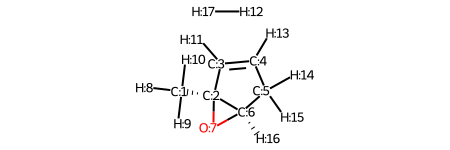

Reactant radicals: {}
Products: [C:1]([C@:2]12[C:3]([H:11])=[C:4]([H:13])[C:5]([H:14])([H:15])[C@@:6]1([H:16])[O:7]2)([H:8])([H:9])[H:10].[H:12][H:17]


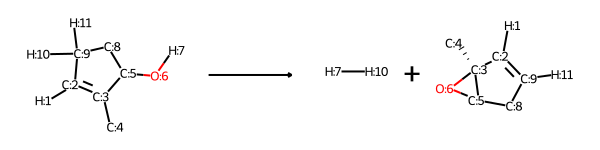

Extracted template: ([#1&+0:1]-[C&+0:2]1=[C&+0:3](-[C:4])-[C:5](-[O&+0:6]-[#1&+0:7])-[C:8]-[C&+0:9]-1(-[#1&+0:10])-[#1&+0:11])>>([#1&+0:10]-[#1&+0:7]).([#1&+0:1]-[C&+0:2]1=[C&+0:9](-[#1&+0:11])-[C:8]-[C:5]2-[O&+0:6]-[C@@&+0:3]-1-2-[C:4])




In [9]:
show_k(38)

56


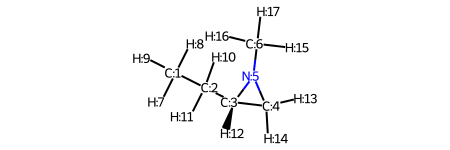

Reactant radicals: {}
Reactants: [C:1]([C:2]([C@@:3]1([H:12])[C:4]([H:13])([H:14])[N:5]1[C:6]([H:15])([H:16])[H:17])([H:10])[H:11])([H:7])([H:8])[H:9]


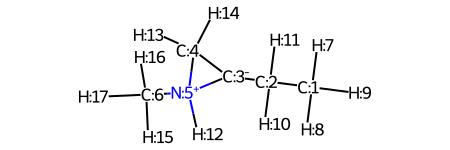

Reactant radicals: {}
Products: [C:1]([C:2]([C-:3]1[C:4]([H:13])([H:14])[N+:5]1([C:6]([H:15])([H:16])[H:17])[H:12])([H:10])[H:11])([H:7])([H:8])[H:9]


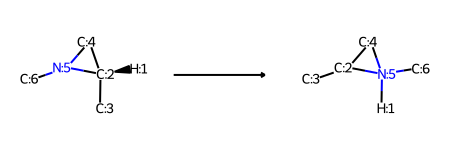

Extracted template: ([#1&+0:1]-[C@&+0:2]1(-[C:3])-[C:4]-[N&+0:5]-1-[C:6])>>([#1&+0:1]-[N&+:5]1(-[C:6])-[C:4]-[C&-:2]-1-[C:3])




In [10]:
show_k(56)